1. [Описание проекта](#start)
2. [Предобработка данных](#preprocessing)
3. [Анализ данных](#analysis)
    * [Типы](#rest_types)
    * [Сети](#chain)
    * [Распределение заведений по улицам и районам](#streets)
    * [Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания](#seats)
4. [Общий вывод](#conclusion)
    

# Описание проекта <a class="anchor" id="start"></a>
Инвесторы хотят открыть новое кафе в Москве. Для них нужно проанализировать рынок общественного питания в городе. Выдать рекомендации

Данные о заведениях общепита Москвы содержат следующую информацию:
* id — идентификатор объекта;
* object_name — название объекта общественного питания;
* chain — сетевой ресторан;
* object_type — тип объекта общественного питания;
* address — адрес;
* number — количество посадочных мест

# Предобработка данных <a class="anchor" id="preprocessing"></a>

Загрузим данные 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.float_format', '{:,.0f}'.format)
import warnings
warnings.filterwarnings('ignore')

In [2]:
try: 
    data = pd.read_csv('/datasets/rest_data.csv')
except:
    data = pd.read_csv('rest_data.csv')

In [3]:
def start(df):
    return display(df.head(5)), df.info()
start(data)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


(None, None)

In [4]:
#Проверим, есть ли дубликаты 
data[data.duplicated(keep = False)] # keep = False выведет все совпадения
#таблица пустая - дубликатов нет

,id,object_name,chain,object_type,address,number


In [5]:
data['id'].nunique() # все id уникальные

15366

In [6]:
data['chain'].unique() # корректные категории в столбце

array(['нет', 'да'], dtype=object)

In [7]:
data['object_type'].unique() # корректные категории в столбце

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Данные загрузились корректно. Пропусков нет, дубликатов нет.

Приведем к более единообразному виду наименования сетей, чтобы группировка была более точной

In [8]:
# приведем названия к нижнему регистру и удалим типы заведений  
data['object_name'] = data['object_name'].str.lower()
for name in ['ресторан', 'кафе', 'пиццерия', 'кальянная', 'детское', 
             'детский клуб', 'пицерия', 'закусочная', 'кальян-бар', 
             'кофейня', 'предприятие быстрого обслуживания', 'бар-буфет',  'пбо', '«', '»']:
    data['object_name'] = data['object_name'].str.replace(name, '')

In [9]:
#выберем одно название для каждой из больших сетей
synonyms = {'макдоналдс': ['mcdonalds', 'москва - макдоналдс', ' макдоналдс'],
            'kfc':['кфц', 'ростикс kfc'],
            'subway' : 'сабвей',
            'бургер кинг' : 'бургер кинг burger king',
            'братья караваевы' : 'кулинарная лавка братьев караваевых',
            'иль патио' : 'иль патио планета суши',
           }
def check_synonyms(cell):
    for name, syn in synonyms.items():
        if cell in syn: return name
    return cell
data['object_name_new'] = data['object_name'].apply(check_synonyms)
    

In [10]:
def name(object_name):
    for item in object_name:
        if 'мята' in object_name: return 'myata'
        if 'myata' in object_name: return 'myata'
        if 'starbucks' in object_name: return 'starbucks' 
        if 'старбакс' in object_name: return 'starbucks'
        if 'штолле' in object_name: return 'штолле'
        if 'прайм' in object_name: return 'прайм'
        if 'prime' in object_name: return 'прайм'
        if 'магбургер' in object_name: return 'магбургер'
    return object_name
data['object_name_new'] = data['object_name_new'].apply(name)

# Анализ данных <a class="anchor" id="analysis"></a>
## Типы заведений <a class="anchor" id="rest_types"></a>

chain,да,нет,total,"да,%"
object_type,,,,
кафе,1396,4703,6099,23
столовая,3,2584,2587,0
ресторан,544,1741,2285,24
предприятие быстрого обслуживания,791,1132,1923,41
бар,37,819,856,4
буфет,11,574,585,2
кафетерий,52,346,398,13
закусочная,56,304,360,16
магазин (отдел кулинарии),78,195,273,29


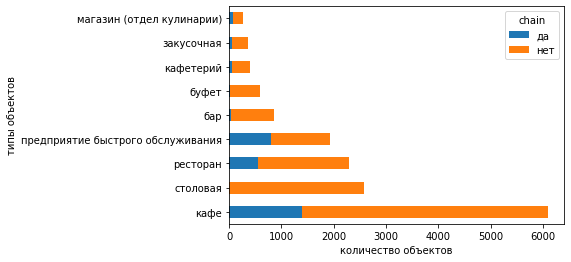

In [11]:
#сгруппируем данные по типу заведения и посчитаем количество заведений каждого типа,
#дополнительно разбив их на сетевые и несетевые
report = data.pivot_table(index = 'object_type', columns = 'chain', values = 'id', aggfunc = 'nunique')
report['total'] = report['да'] + report['нет']
report['да,%'] = report['да']/report['total']*100
#report['нет,%'] = report['нет']/report['total']*100
report = report.sort_values(by='total', ascending=False)
display(report)
report[['да', 'нет']].plot(kind='barh', stacked=True)
plt.ylabel('типы объектов')
plt.xlabel('количество объектов');

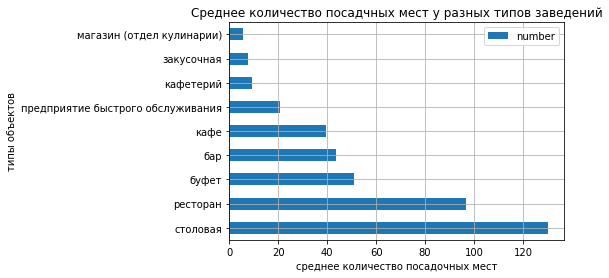

In [12]:
seat_num = data.groupby('object_type').agg({'number' : 'mean'}).sort_values(by='number', ascending=False)
seat_num.plot(kind = 'barh', grid = True)
plt.ylabel('типы объектов')
plt.xlabel('среднее количество посадочных мест')
plt.title('Среднее количество посадчных мест у разных типов заведений');

**Выводы**
* **Соотношение видов объектов общественного питания по количеству**
Количество кафе намного превышает количество всех других типов заведений. Затем идут *столовая*, *ресторан*  и *пбо*.


* **Соотношение сетевых и несетевых заведений по количеству**
Несетевых заведений намного больше


* **Для какого вида объекта общественного питания характерно сетевое распространение**
Наибольшая доля сетевых заведений у *пбо (41%), кулинарии (29%) и  *кафе* и *ресторанов* (23-24%) 


* **Какой вид предоставляет в среднем самое большое количество посадочных мест?** 
столовая

## Сети <a class="anchor" id="chain"></a>
Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [13]:
data_chain = data.query('chain == "да"') # только сети
data_chain = data_chain.groupby('object_name_new').agg({'id' : 'count', 'number' : 'mean'})\
                    .sort_values(by='id', ascending=False)\
                    .query('id>1') #для анализа возьмем сети с количеством заведений более одного 
                                   #(если в сети одно заведение это скорее всего из-за некорретной записи названия)
data_chain.head()

,id,number
object_name_new,,
макдоналдс,173,87
kfc,163,56
шоколадница,157,57
бургер кинг,144,48
теремок,94,26


In [14]:
print(np.percentile(data_chain['id'], [25])) #25й перцентиль - мало заведений и мало посадочных мест, остальное - много

[2.]


In [15]:
print(np.percentile(data_chain['number'], [25])) 

[19.2]


,object_name_new,медианное число заведений,медианное число мест
группа,,,
Мало заведений - Мало мест,43,3,15
Мало заведений - Много мест,123,3,67
Много заведений - Мало мест,13,16,8
Много заведений - Много мест,38,26,56


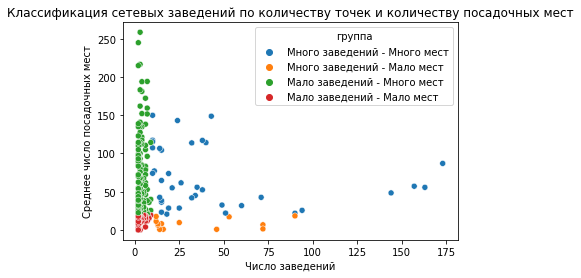

In [16]:
#группировка заведений по 4 группам.
data_chain['rest_num'] = 'Мало заведений'
data_chain.loc[data_chain['id'] > 9 , 'rest_num'] = 'Много заведений'

data_chain['seat_num'] = 'Мало мест'
data_chain.loc[data_chain['number'] > 20 , 'seat_num'] = 'Много мест'

data_chain['группа'] = data_chain['rest_num'].astype(str) + ' - ' + data_chain['seat_num'].astype(str)

sns.scatterplot(data=data_chain, x='id', y='number', hue='группа')
plt.xlabel('Число заведений')
plt.ylabel('Cреднее число посадочных мест')
plt.title('Классификация сетевых заведений по количеству точек и количеству посадочных мест')

#переименуем название столбцов сводной таблицы
data_chain.reset_index().groupby('группа').agg({'object_name_new' : 'nunique', 'id' : 'median', 'number' : 'median'})\
                                          .rename(columns = {'object_name' : 'число сетей', 
                                                             'id' : 'медианное число заведений',
                                                             'number' : 'медианное число мест'})


**Вывод** : для сетевых заведений более характерно *мало заведений - много мест*

## Распределение заведений по улицам и районам <a class="anchor" id="streets"></a>

In [17]:
#выделим название алицы в отдельный столбец
def get_street(cell):
    #разбиваем адрес на части и для каждой части проверяем, есть ли в ней тип улицы
    for addr_part in cell.split(','):
        for s_type in ['улица', 'бульвар', 'проспект', 'переулок', 'шоссе', 'тупик', 'набережная', 'площадь', 'пр-т', 'ул', 'пер', 'наб']:
            if s_type in addr_part: return addr_part
    #если ничего не нашли, возвращаем второй элемент
    return cell.split(',')[1]

data['street'] = data['address'].apply(get_street) 
data['street'] = data['street'].str.strip() #убираем лишние пробелы
data.head()

,id,object_name,chain,object_type,address,number,object_name_new,street
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,сметана,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,родник,улица Талалихина
2,24309,академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,академия,Абельмановская улица
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,пиццетория,Абрамцевская улица
4,119365,вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,вишневая метель,Абрамцевская улица


In [18]:
#загрузим внешние данные о принадлежности улиц к районам
from io import BytesIO
import requests
spreadsheet_id = '1J2bgBn4BAFmf3Ulkn0F91u8SRqCRBPjDOAHRYMYpnwk'
#https://docs.google.com/spreadsheets/d/1J2bgBn4BAFmf3Ulkn0F91u8SRqCRBPjDOAHRYMYpnwk/edit?usp=sharing
filename = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(filename)
df = pd.read_csv(BytesIO(r.content))
df.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


,id
street,
проспект Мира,204
Профсоюзная улица,183
Ленинградский проспект,173
Пресненская набережная,167
Варшавское шоссе,165
Ленинский проспект,148
проспект Вернадского,132
Кутузовский проспект,114
Каширское шоссе,112


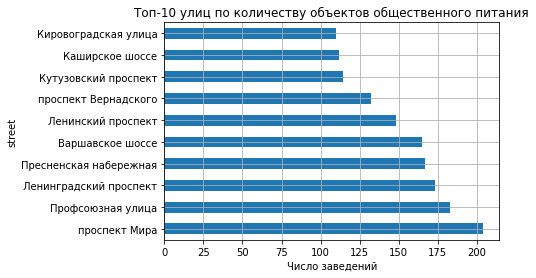

In [19]:
#уберем город Зеленоград из списка улиц
top_10str = data.query('street != "город Зеленоград"')\
    .groupby('street').agg({'id' : 'count'}).sort_values(by='id', ascending=False).head(10)
display(top_10str)
top_10str.query('street != "город Зеленоград"').plot(kind = 'barh', grid = True, legend=False);
plt.title('Tоп-10 улиц по количеству объектов общественного питания')
plt.xlabel('Число заведений');

**Вывод №1:** Количество заведений на улице зависит прежде всего от протяженности улицы, а не от ее расположения. У Москвы радиальная планировка. Протяженные шоссе, проспекты начинаются в центре и проходя через весь город за МКАД, на таких улица больше всего заведений.

In [20]:
# переименование столбца 'streetname'на 'street_name' и приведение его значений к нижнему регистру
df = df.rename(columns = {'streetname': 'street'})
 
# объединение top10_streets и df
district = top_10str.merge(df, on = 'street', how = 'left') 
display(district)
district[district['area'].isna()].shape[0] # проверка: число адресов без районов

,street,id,areaid,okrug,area
0,проспект Мира,204,70,СВАО,Алексеевский район
1,проспект Мира,204,86,СВАО,Ярославский Район
2,проспект Мира,204,78,СВАО,Район Марьина роща
3,проспект Мира,204,79,СВАО,Останкинский район
4,проспект Мира,204,81,СВАО,Район Ростокино
5,проспект Мира,204,82,СВАО,Район Свиблово
6,проспект Мира,204,16,ЦАО,Мещанский район
7,Профсоюзная улица,183,123,ЮЗАО,Академический район
8,Профсоюзная улица,183,132,ЮЗАО,Район Черемушки
9,Профсоюзная улица,183,134,ЮЗАО,Район Ясенево


0

**Вывод №2:** Все улицы из топ_10 находятся сразу в нескольких районах, настолько они длинные.

In [21]:
#найдем улицы с одним заведением и определим к каким районам они относятся
one_street = data.groupby('street').agg({'id':'count'}).query('id == 1')
# соединим таблицы, чтобы получить информацию в каких районах они находятся
district_one = one_street.merge(df, on = 'street', how = 'left') 
district_one_top = district_one.groupby('area').agg({'street' : 'nunique'})\
                .sort_values(by='street', ascending=False).head(10)
display(district_one_top)
#сгруппируем по округам 
district_one_top = district_one_top.merge(df[['area', 'okrug']], on = 'area', how = 'left') 
district_one_top.groupby('okrug').agg({'area' : 'nunique'})

,street
area,
Таганский район,27
Район Хамовники,26
Басманный район,25
Тверской район,20
Пресненский район,20
Район Арбат,18
Район Марьина роща,18
Мещанский район,16
Район Сокольники,15


,area
okrug,
ВАО,1
СВАО,1
ЦАО,8


**Вывод №3:** Большинство улиц с одним объектом это маленькие улицы, они находятся в центральных районах

## Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания <a class="anchor" id="seats"></a>

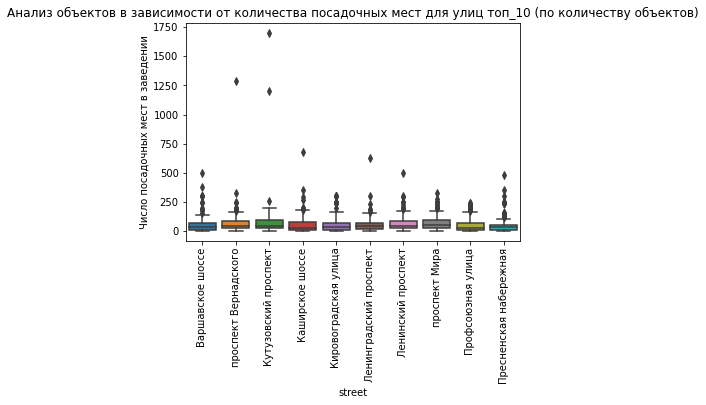

In [22]:
top_10 = data.query('street in @top_10str.index') # выбираем данные по улицам топ_10
ax = sns.boxplot(x='street', y='number', data=top_10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.ylabel('Число посадочных мест в заведении')
plt.title('Анализ объектов в зависимости от количества посадочных мест для улиц топ_10 (по количеству объектов)');

**Вывод №1:** На улицах Кутузовский проспект, пр Вернадского, Каширское шоссе, Ленинградский просп, Ленинский просп самые большие выбросы - заведения с количеством посадочных мест свыше 500. Выбросы свыше 250-300 есть на всех этих улицах.

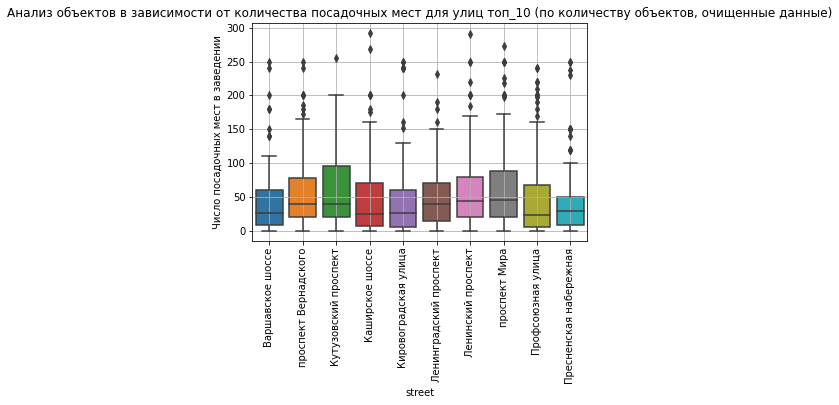

In [23]:
#Уберем выбросы свыше 300 посадочных мест, чтобы удобнее было проанализировать остальные данные
ax = sns.boxplot(x='street', y='number', data=top_10.query('number < 300'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.grid(True)
plt.ylabel('Число посадочных мест в заведении')
plt.title('Анализ объектов в зависимости от количества посадочных мест для улиц топ_10 (по количеству объектов, очищенные данные)');

In [24]:
top_10.describe()

,id,number
count,"1,508","1,508"
mean,"126,666",58
std,"72,454",90
min,"19,654",0
25%,"29,386",12
50%,"150,752",38
75%,"188,530",75
max,"223,439","1,700"


**Вывод №2:** Медианное количество посадочных мест примерно одинаковое у всех от 25 до 50 примерно. Сильно выделяется город Зеленоград, с медианой около 70, там находятся более крупные заведения, также свеча более вытянута, это означает, что в Зеленограде большой разброс по количеству мест у заведений. У Варшавского ш, Пресненской наб, Ленинградского просп. компактные свечи,  расположенные низко, это значит, что на этих улицах маленький разброс по количеству мест и оно оносительно невысоко.

In [ ]:
<div class="alert alert-info"> <b>Комментарий студента:</b> Поясни, пожалуйста, что имеешь в виду под оценкой гистограмм?</div>

## Общий вывод <a class="anchor" id="conclusion"></a>

Самый распространенный вид объектов - это кафе. 

Несетевых заведений все-таки намного больше чем сетевых. Наибольший процент сетевых заведений у кафе, ресторанов и пбо (Макдоналдс, БургерКинг).

Самые большие заведения по количеству посадочных мест - это столовые, затем идут ретсораны.

Для сетей характерны крупные заведения на большое количество мест, с небольшим количеством точек. Крупных сетей с большими точками немного, но они есть. Много заведений - мало мест - совсем немногочисленная группа.

Больше всего заведений находится на протяженных улицах - проспектах, шоссе, которые проходят через несколько районов города. 

Презентация: <https://docs.google.com/presentation/d/18ydf452QL_RB0K2q-HWNPEMyFTxn0elwHP14y9GLkwY/edit?usp=sharing>

pdf формат: <https://disk.yandex.ru/d/wravPAaefSz7BA>